In [24]:
import nfl_data_py as nfl
import pandas as pd
import os
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
pbp = pd.read_csv('scrape/nfl_data_py/df_pbp_2016_2022.csv')
pbp_reg = pbp[(pbp['season_type'] == 'REG')]
pbp_post = pbp[(pbp['season_type'] == 'POST')]

C:\Users\grant\AppData\Local\Temp\ipykernel_21136\2654047502.py:1: DtypeWarning: Columns (179,180,182,183,189,190,193,194,197,198,203,204,205,206,209,210,213,214,218,219,220,222,224,226,233,234,235,236,237,238,243,244,245,248,249,253,254,255,260,262,263,266,267,268,269,283,284,301) have mixed types. Specify dtype option on import or set low_memory=False.
  pbp = pd.read_csv('scrape/nfl_data_py/df_pbp_2016_2022.csv')


In [26]:
lines = pbp_reg[['season', 'week','home_team', 'away_team', 'spread_line', 'total_line', 'home_score', 'away_score']].drop_duplicates().reset_index(drop=True)
lines['spread'] = lines['home_score'] - lines['away_score']
lines['total'] = lines['home_score'] + lines['away_score']
lines.loc[(lines['spread'] > lines['spread_line']),'home_cover'] = True
lines.loc[(lines['spread'] < lines['spread_line']),'home_cover'] = False
lines.loc[(lines['total'] > lines['total_line']),'over_cover'] = True
lines.loc[(lines['total'] < lines['total_line']),'over_cover'] = False
lines.head()

,season,week,home_team,away_team,spread_line,total_line,home_score,away_score,spread,total,home_cover,over_cover
0,2016,1,BAL,BUF,3.0,44.5,13,7,6,20,True,False
1,2016,1,DEN,CAR,-3.0,40.5,21,20,1,41,True,True
2,2016,1,HOU,CHI,5.5,43.0,23,14,9,37,True,False
3,2016,1,NYJ,CIN,1.0,42.0,22,23,-1,45,False,True
4,2016,1,PHI,CLE,3.5,41.0,29,10,19,39,True,False


In [27]:
def chart_by_season(df, x, y):
    
    df = df[df[y].notna()].groupby(x)[y].mean().reset_index()
    
    plt.figure(figsize=(10, 6))
    plt.plot(df[x], df[y], marker='o')

    for xi, yi in zip(df[x], df[y]):
        plt.annotate(str(round(yi,2)), (xi, yi), textcoords="offset points", xytext=(0,5), ha='center')

    plt.title(f'{y} by {x}')
    plt.xlabel(f'{x}')
    plt.ylabel(f'{y}')
    plt.grid(True)
    plt.show()

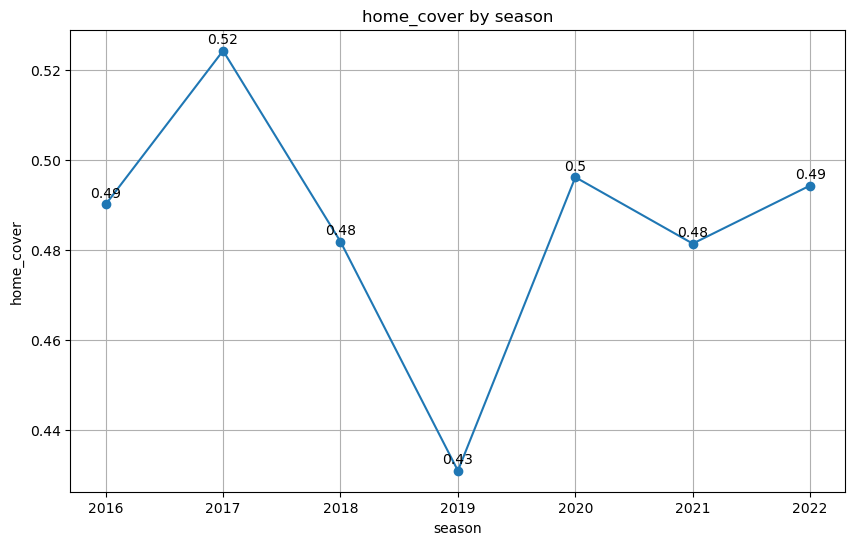

In [28]:
chart_by_season(lines.copy(), x='season', y='home_cover')

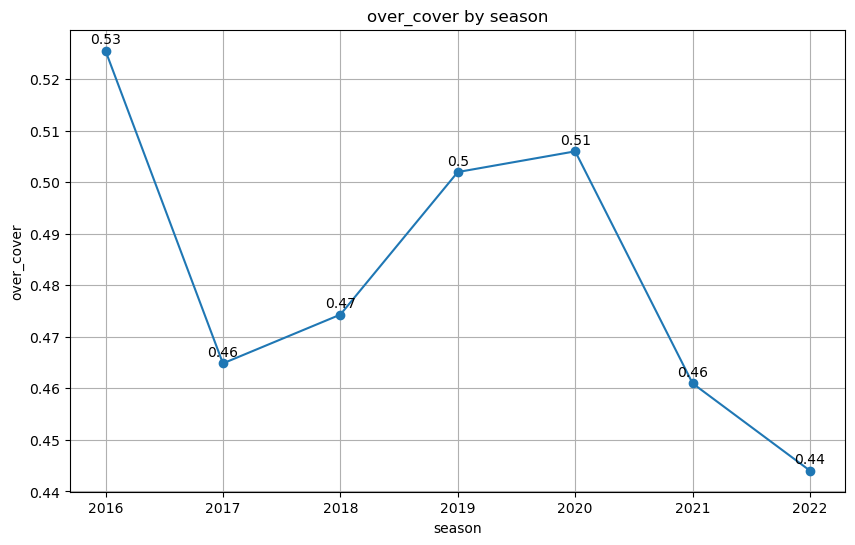

In [29]:
chart_by_season(lines.copy(), x='season', y='over_cover')

In [30]:
post_season_teams = pbp_post[['season', 'home_team', 'away_team']].drop_duplicates().reset_index(drop=True)
post_season_teams = pd.concat([post_season_teams[['season', 'home_team']].rename(columns={'home_team': 'team'})
                , post_season_teams[['season', 'away_team']].rename(columns={'away_team': 'team'})])
post_season_teams.drop_duplicates(inplace=True)
post_season_teams['playoff_team'] = True
post_season_teams.head()

,season,team,playoff_team
0,2016,SEA,True
1,2016,PIT,True
2,2016,GB,True
3,2016,HOU,True
4,2016,DAL,True


In [31]:
df = pbp_reg[['season', 'week', 'home_team', 'away_team', 'home_score', 'away_score']].drop_duplicates().reset_index(drop=True)
df['home_win'] = df['home_score'] > df['away_score']
df['home_loss'] = df['home_score'] < df['away_score']
df['tie'] = df['home_score'] == df['away_score']
df['away_win'] = df['away_score'] > df['home_score']
df['away_loss'] = df['away_score'] < df['home_score']

home_df = df[['season', 'week', 'home_team', 'home_win', 'home_loss', 'tie']].copy()
home_df.columns = ['season', 'week', 'team', 'win', 'loss', 'tie']

away_df = df[['season', 'week', 'away_team', 'away_win', 'away_loss', 'tie']].copy()
away_df.columns = ['season', 'week', 'team', 'win', 'loss', 'tie']

combined_df = pd.concat([home_df, away_df])

combined_df['win'] = combined_df['win'].astype(int)
combined_df['loss'] = combined_df['loss'].astype(int)
combined_df['tie'] = combined_df['tie'].astype(int)

combined_df = (combined_df.groupby(['season', 'team', 'week'])
                            .agg({'win': 'sum', 'loss': 'sum', 'tie': 'sum'})
                            .reset_index())
bye_weeks = combined_df.groupby(['season', 'team'])['week'].apply(set).reset_index()
bye_weeks['bye_week'] = bye_weeks.apply(lambda row: set(range(1, max(row['week']) + 1)) - row['week'], axis=1)
bye_weeks['bye_week'] = bye_weeks['bye_week'].apply(lambda x: list(x)[0] if len(x) == 1 else None)
# manual fix for BUF CIN cancelled game week 17 of the 2022 season
bye_weeks.loc[(bye_weeks['season'] == 2022) & (bye_weeks['team'] == 'BUF'), 'bye_week'] = 7
bye_weeks.loc[(bye_weeks['season'] == 2022) & (bye_weeks['team'] == 'CIN'), 'bye_week'] = 10

combined_df = pd.merge(combined_df, bye_weeks[['season', 'team', 'bye_week']], on=['season', 'team'], how='left')
combined_df['bye'] = combined_df.apply(lambda row: 1 if row['week'] >= row['bye_week'] else 0, axis=1)
combined_df.drop('bye_week', axis=1, inplace=True)

df = (combined_df.groupby(['season', 'team', 'week'])
                        .agg({'win': 'sum', 'loss': 'sum', 'tie': 'sum', 'bye': 'max'})
                        .groupby(level=[0, 1])
                        .cumsum()
                        .reset_index())

df['bye'] = df['bye'].apply(lambda x: 1 if x > 0 else 0)

df['win_adj'] = df['win'] + df['tie'] * 0.5

df.head(16)


,season,team,week,win,loss,tie,bye,win_adj
0,2016,ARI,1,0,1,0,0,0.0
1,2016,ARI,2,1,1,0,0,1.0
2,2016,ARI,3,1,2,0,0,1.0
3,2016,ARI,4,1,3,0,0,1.0
4,2016,ARI,5,2,3,0,0,2.0
5,2016,ARI,6,3,3,0,0,3.0
6,2016,ARI,7,3,3,1,0,3.5
7,2016,ARI,8,3,4,1,0,3.5
8,2016,ARI,10,4,4,1,1,4.5
9,2016,ARI,11,4,5,1,1,4.5


In [32]:
df = pd.merge(df, post_season_teams, on=['season', 'team'], how='left')

In [33]:
df.head(16)

,season,team,week,win,loss,tie,bye,win_adj,playoff_team
0,2016,ARI,1,0,1,0,0,0.0,NaN
1,2016,ARI,2,1,1,0,0,1.0,NaN
2,2016,ARI,3,1,2,0,0,1.0,NaN
3,2016,ARI,4,1,3,0,0,1.0,NaN
4,2016,ARI,5,2,3,0,0,2.0,NaN
5,2016,ARI,6,3,3,0,0,3.0,NaN
6,2016,ARI,7,3,3,1,0,3.5,NaN
7,2016,ARI,8,3,4,1,0,3.5,NaN
8,2016,ARI,10,4,4,1,1,4.5,NaN
9,2016,ARI,11,4,5,1,1,4.5,NaN


In [34]:
def playoff_chance_pivots(df):
    total = df.pivot_table(index='win', columns='week', values='team', aggfunc='count', margins=True).fillna(0).astype(int)
    print(total)
    playoff = df[df['playoff_team'] == True].pivot_table(index='win', columns='week', values='team', aggfunc='count', margins=True).fillna(0).astype(int)
    print(playoff)
    rate = round((playoff / total) * 100,1)
    print(rate)

filtered_df = df[(df['bye'] == 0) & (df['tie'] == 0)]
filtered_df
playoff_chance_pivots(filtered_df[filtered_df['week'] <= 3])

week    1    2    3  All
win                     
0     108   56   30  194
1     108  102   74  284
2       0   56   77  133
3       0    0   31   31
All   216  214  212  642
week   1   2   3  All
win                  
0     26   5   1   32
1     64  48  20  132
2      0  37  47   84
3      0   0  22   22
All   90  90  90  270
week     1     2     3   All
win                         
0     24.1   8.9   3.3  16.5
1     59.3  47.1  27.0  46.5
2      NaN  66.1  61.0  63.2
3      NaN   NaN  71.0  71.0
All   41.7  42.1  42.5  42.1


In [35]:
fumbles = pbp_reg[pbp_reg['fumble_lost'] == 1]
fumbles = fumbles[['season', 'week', 'fumbled_1_team']]
fumbles.rename(columns={'fumbled_1_team': 'team'}, inplace=True)
fumbles = fumbles.groupby(['season', 'week','team']).size().reset_index(name='fumbles').sort_values(['season','team', 'week'])

interceptions = pbp_reg[pbp_reg['interception'] == 1]
interceptions = interceptions[['season', 'week', 'posteam']]
interceptions.rename(columns={'posteam': 'team'}, inplace=True)
interceptions = interceptions.groupby(['season', 'week','team']).size().reset_index(name='interceptions').sort_values(['season', 'team', 'week'])

turnovers = pd.merge(fumbles, interceptions, on=['team', 'week', 'season'], how='outer')
turnovers.fillna(0, inplace=True)
turnovers['turnovers'] = turnovers['fumbles'] + turnovers['interceptions']

schedule = pbp_reg[pbp_reg['desc'] == 'END GAME']
schedule = schedule[['season', 'week', 'home_team', 'away_team', 'home_score', 'away_score']].drop_duplicates().reset_index(drop=True)

df = pd.merge(schedule, turnovers[['season', 'week','team', 'turnovers']].rename(columns={'team': 'home_team', 'turnovers': 'home_turnovers'}), on=['season', 'week', 'home_team'], how='left')
df = pd.merge(df, turnovers[['season', 'week','team', 'turnovers']].rename(columns={'team': 'away_team', 'turnovers': 'away_turnovers'}), on=['season', 'week', 'away_team'], how='left')
df.fillna(0, inplace=True)
df['home_vs_away_turnovers'] = df['home_turnovers'] - df['away_turnovers']
df['home_vs_away_score'] = df['home_score'] - df['away_score']
df['home_outcome'] = 'Loss'
df.loc[df['home_vs_away_score'] > 0, 'home_outcome'] = 'Win'
df.loc[df['home_vs_away_score'] == 0, 'home_outcome'] = 'Tie'
df['home_win_binary'] = 0
df.loc[df['home_vs_away_score'] > 0, 'home_win_binary'] = 1
df.head()

,season,week,home_team,away_team,home_score,away_score,home_turnovers,away_turnovers,home_vs_away_turnovers,home_vs_away_score,home_outcome,home_win_binary
0,2016,1,BAL,BUF,13,7,1.0,0.0,1.0,6,Win,1
1,2016,1,DEN,CAR,21,20,3.0,1.0,2.0,1,Win,1
2,2016,1,HOU,CHI,23,14,1.0,1.0,0.0,9,Win,1
3,2016,1,NYJ,CIN,22,23,1.0,1.0,0.0,-1,Loss,0
4,2016,1,PHI,CLE,29,10,0.0,1.0,-1.0,19,Win,1


In [36]:
round(df['home_outcome'].value_counts() / len(df), 3)

Win     0.544
Loss    0.451
Tie     0.005
Name: home_outcome, dtype: float64

In [37]:
round(df[df['season'] != 2020]['home_outcome'].value_counts() / len(df[df['season'] != 2020]), 3)

Win     0.552
Loss    0.443
Tie     0.005
Name: home_outcome, dtype: float64

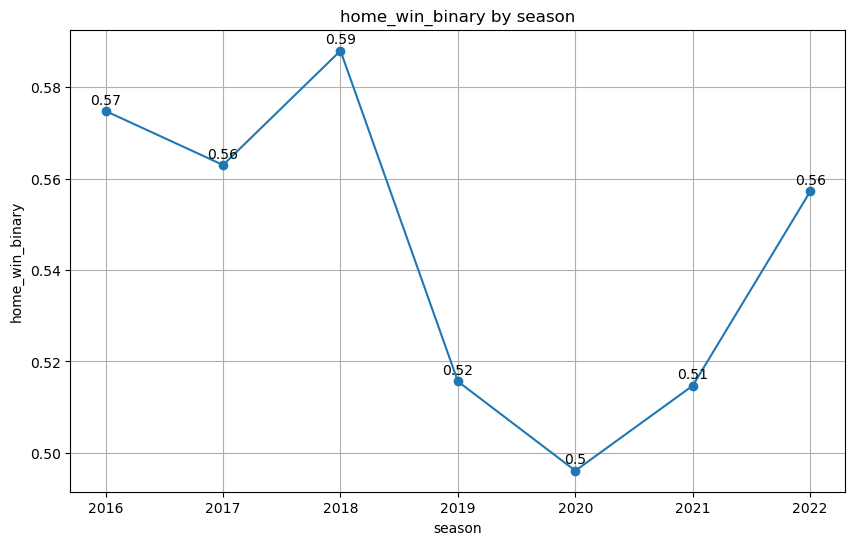

In [38]:
chart_by_season(df.copy(), x='season', y='home_win_binary')

In [39]:
df['home_vs_away_score'].mean()

1.4964147821290679

In [40]:
df[df['season'] != 2020]['home_vs_away_score'].mean()

1.7334617854849068

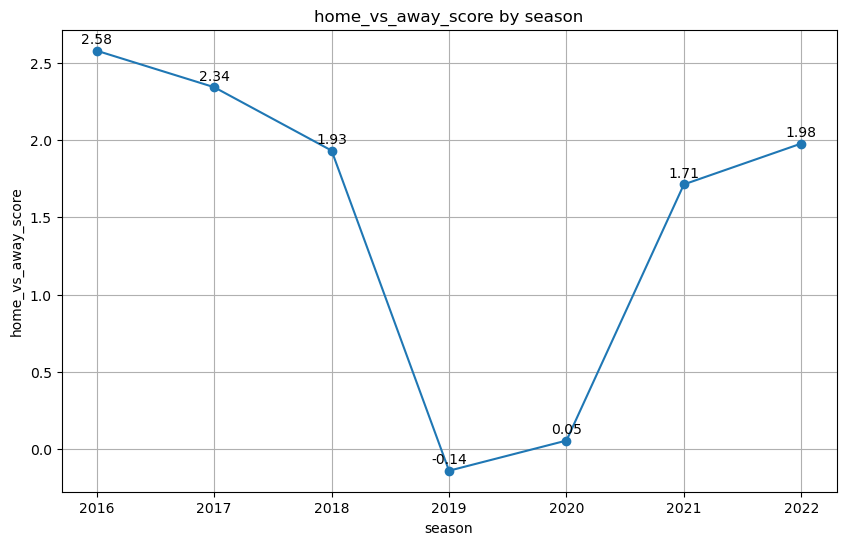

In [41]:
chart_by_season(df.copy(), x='season', y='home_vs_away_score')

In [42]:
correlation_coefficient = df['home_vs_away_turnovers'].corr(df['home_vs_away_score'])
correlation_coefficient

-0.5836223762967452

In [43]:
win_rate_by_turnover_diff = df.groupby('home_vs_away_turnovers')['home_outcome'].apply(lambda x: (x == 'Win').sum() / len(x)).reset_index()
win_rate_by_turnover_diff.columns = ['Turnover Differential', 'Win Rate']

num_games_by_turnover_diff = df.groupby('home_vs_away_turnovers')['home_outcome'].count().reset_index()
num_games_by_turnover_diff.columns = ['Turnover Differential', 'Number of Games']

win_rate_by_turnover_diff = win_rate_by_turnover_diff.merge(num_games_by_turnover_diff, on='Turnover Differential')

win_rate_by_turnover_diff['Win Rate'] = win_rate_by_turnover_diff['Win Rate'].round(2)

win_rate_by_turnover_diff

,Turnover Differential,Win Rate,Number of Games
0,-7.0,1.00,1
1,-6.0,1.00,2
2,-5.0,0.86,7
3,-4.0,0.98,42
4,-3.0,0.95,103
5,-2.0,0.90,220
6,-1.0,0.69,331
7,0.0,0.58,412
8,1.0,0.34,357
9,2.0,0.18,191


In [44]:
df[(df['home_vs_away_turnovers'] == -5.0) & (df['home_outcome'] == 'Tie')]

,season,week,home_team,away_team,home_score,away_score,home_turnovers,away_turnovers,home_vs_away_turnovers,home_vs_away_score,home_outcome,home_win_binary
517,2018,1,CLE,PIT,21,21,1.0,6.0,-5.0,0,Tie,0


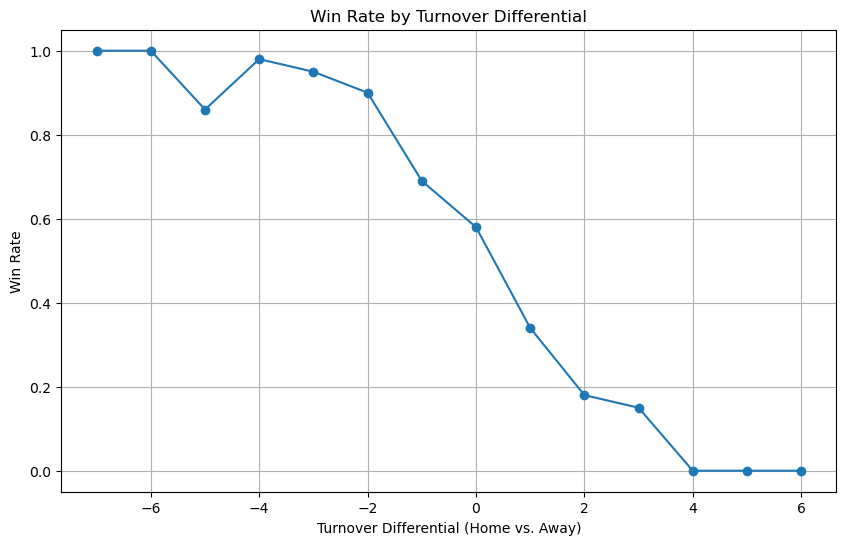

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(win_rate_by_turnover_diff['Turnover Differential'], win_rate_by_turnover_diff['Win Rate'], marker='o')
plt.title('Win Rate by Turnover Differential')
plt.xlabel('Turnover Differential (Home vs. Away)')
plt.ylabel('Win Rate')
plt.grid(True)
plt.show()

In [46]:
avg_home_turnover_diff = df['home_vs_away_turnovers'].mean()
avg_away_turnover_diff = -avg_home_turnover_diff
avg_home_turnover_diff, avg_away_turnover_diff

(-0.03695532266960838, 0.03695532266960838)